## Final Task:
This is your final evaluation for the project. As decided, we will be predicting images of people into three classes: `without_mask`, `mask_weared_incorrect` and `with_mask`. 

In [ ]:
import tensorflow as tf

### Loading the dataset
Make a copy of the dataset given to you in your Google Drive (keep it outside, don't put it in any folder to avoid inconvenience). Ensure it is named as `Mask_Dataset` or change the path (the variable `data_dir`) accordingly.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib

path='/content/drive/MyDrive/Mask_Dataset/'
data_dir = pathlib.Path(path)

### Know the Dataset
Most of the code is written for you as you aren't used to these libraries. You are to go through the documentation for your benefit.

In [ ]:
# Print image count
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

8992


In [ ]:
# Print Output Labels
import os
output_classes = os.listdir(data_dir)
print(output_classes)

['mask_weared_incorrect', 'with_mask', 'without_mask']


[2994, 3004, 2994]


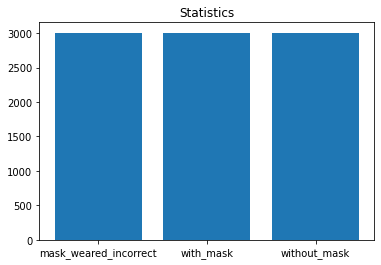

In [ ]:
# Plot count of each ouput label
import matplotlib.pyplot as plt

count=[]
for label in output_classes:
  this_path=path+label
  dir=pathlib.Path(this_path)
  im_count=os.listdir(dir)
  count.append(len(im_count))

print(count)

plt.bar(output_classes,count)
plt.title("Statistics")
plt.show()

Pictures of mask_weared_incorrect: 


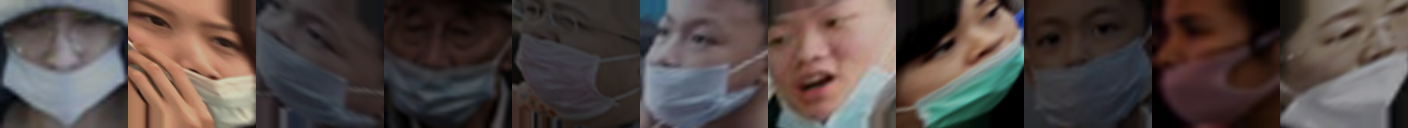

Pictures of with_mask: 


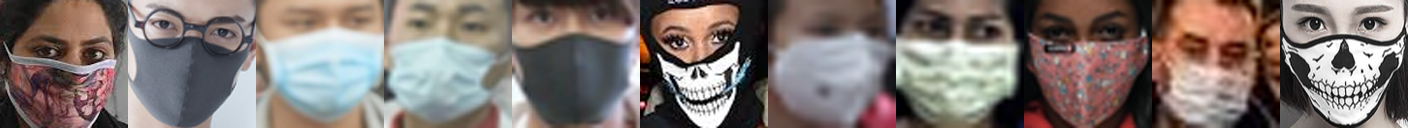

Pictures of without_mask: 


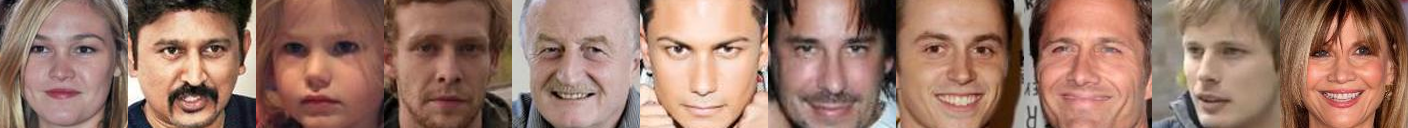

In [ ]:
# Check some sample images (Use of cv2)
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

for label in output_classes:
  this_path=path+label
  dir=pathlib.Path(this_path)
  l = []
  images = os.listdir(dir)
  for i,im in enumerate(images):
    if i%295==0:
      l.append(cv2.imread(this_path+'/'+im))
  print("Pictures of "+label+": ")
  hori = np.concatenate(l, axis=1)
  cv2_imshow(hori)


# Your code

In [ ]:
# Check shape of the images in your dataset. This will be helpful while specifying input_shape in your Transfer Learning Model
import cv2
import numpy as np

for cls in output_classes:
  print("In",cls,"dataset:")
  for i in range(1,3):
    im = cv2.imread(path+cls+"/"+str(i)+".png")
    print(im.shape)
SHAPE = im.shape

In mask_weared_incorrect dataset:
(128, 128, 3)
(128, 128, 3)
In with_mask dataset:
(128, 128, 3)
(128, 128, 3)
In without_mask dataset:
(128, 128, 3)
(128, 128, 3)


In [ ]:
# # Check if all the images have same shape, else you need to resize them to some common size
# # The code provided as it is above in the template will help 
SHAPE = (128,128,3)

imgs = data_dir.glob('*/*.png')
flag = 0
for i in imgs:
  im = cv2.imread(i.as_posix())
  if im.shape != SHAPE:
    flag = 1
    print("Image of new shape ", im.shape," found.")
    break
if flag == 0:
  print("All images have same shape, ", SHAPE)

### Model Definition
Choose a model for Transfer Learning (You may also experment with multiple models and keep all of them in this notebook)

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

In [ ]:
# Choose and define base model
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(weights = 'imagenet',include_top=False,input_shape=SHAPE)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# Print base model summary and have a look at the layers
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
# As we're using Transfer Learning, you do not need to train all the layers. Freeze all of the layers or train some layers (experiment)
base_model.trainable = False

In [ ]:
# Append Fully connected/custom Conv2D/Dropout/MaxPooling layers to the base model
inputs = Input(shape = SHAPE)
x = base_model(inputs, training = False)
x = Flatten()(x)
x = Dense(2048,activation = 'relu')(x)
x = Dropout(0.25,seed=1)(x)

In [ ]:
# Add the final output layer
output_ = Dense(3,activation = 'softmax')(x)
model = Model(inputs,output_)

In [ ]:
# Print your model's summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2048)              16779264  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 31,500,099
Trainable params: 16,785,411
Non-tra

In [ ]:
# Compile you model (set the parameters like loss/optimizers/metrics)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics='accuracy')

### Data Augmentation and Pre-processing
Augment the data. You may also try dyanamic augmentation using [`tf.keras.preprocessing.image.ImageDataGenerator `](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).   
You may use [`tf.keras.applications.vgg16.preprocess_input`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input)(or some other base model's utility) for pre-processing (can also be passed as a parameter to `ImageDataGenerator`)

In [ ]:
from keras.applications.vgg16 import preprocess_input # Change according to your base model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Your code 
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range = 0.2,
    zoom_range = 0.2,
    validation_split = 0.1
)



### Training and Validation Dataset  
Split the dataset into training and validation (We'll be looking for your validation accuracy, assume we are using complete dataset for now). 

Hint: `flow_from_directory` used with `ImageDataGenerator` will simplify things for you.

In [ ]:
# Your code
train_generator = datagen.flow_from_directory(
    path,
    target_size=SHAPE[:-1],
    subset='training'
)

val_generator = datagen.flow_from_directory(
    path,
    target_size=SHAPE[:-1],
    subset='validation'
)


Found 8094 images belonging to 3 classes.
Found 898 images belonging to 3 classes.


### Training  
Train your model for some epochs and plot the graph. Try and save your best model. Experiment with the parameters of `model.fit`

In [ ]:
from gc import callbacks
from keras.callbacks import ModelCheckpoint
# ModelCheckpoint is helpful to save the model giving best results (brownie points)

ckptpath = '/content/drive/MyDrive/Mask_models/vgg16'
model_checkpoint_callback = ModelCheckpoint(
    filepath=ckptpath,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True)

history = model.fit(train_generator,
                    epochs=20,
                    validation_data=val_generator,
                    verbose=1,
                    callbacks=[model_checkpoint_callback]
                  )

Epoch 1/20
253/253 [==============================] - 103s 354ms/step - loss: 0.5189 - accuracy: 0.8614 - val_loss: 0.2201 - val_accuracy: 0.9143
Epoch 2/20
253/253 [==============================] - 71s 282ms/step - loss: 0.2115 - accuracy: 0.9192 - val_loss: 0.2449 - val_accuracy: 0.8964
Epoch 3/20
253/253 [==============================] - 78s 305ms/step - loss: 0.1767 - accuracy: 0.9369 - val_loss: 0.1778 - val_accuracy: 0.9376
Epoch 4/20
253/253 [==============================] - 80s 317ms/step - loss: 0.1713 - accuracy: 0.9371 - val_loss: 0.1518 - val_accuracy: 0.9388
Epoch 5/20
253/253 [==============================] - 83s 328ms/step - loss: 0.1538 - accuracy: 0.9453 - val_loss: 0.1332 - val_accuracy: 0.9510
Epoch 6/20
253/253 [==============================] - 77s 304ms/step - loss: 0.1534 - accuracy: 0.9433 - val_loss: 0.1494 - val_accuracy: 0.9499
Epoch 7/20
253/253 [==============================] - 75s 296ms/step - loss: 0.1276 - accuracy: 0.9524 - val_loss: 0.1370 - val_a

### Evaluate the performance

In [ ]:
# Fine tuning the model

base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics='accuracy')

history2 = model.fit(train_generator,
                    epochs=5,
                    validation_data=val_generator,
                    verbose=1,
                    callbacks=[model_checkpoint_callback]
                  )

Epoch 1/5
253/253 [==============================] - 97s 367ms/step - loss: 0.0844 - accuracy: 0.9701 - val_loss: 0.0631 - val_accuracy: 0.9822
Epoch 2/5
253/253 [==============================] - 85s 337ms/step - loss: 0.0470 - accuracy: 0.9838 - val_loss: 0.0765 - val_accuracy: 0.9744
Epoch 3/5
253/253 [==============================] - 86s 340ms/step - loss: 0.0337 - accuracy: 0.9896 - val_loss: 0.0727 - val_accuracy: 0.9755
Epoch 4/5
253/253 [==============================] - 85s 335ms/step - loss: 0.0377 - accuracy: 0.9868 - val_loss: 0.0696 - val_accuracy: 0.9788
Epoch 5/5
253/253 [==============================] - 90s 355ms/step - loss: 0.0307 - accuracy: 0.9899 - val_loss: 0.0414 - val_accuracy: 0.9855


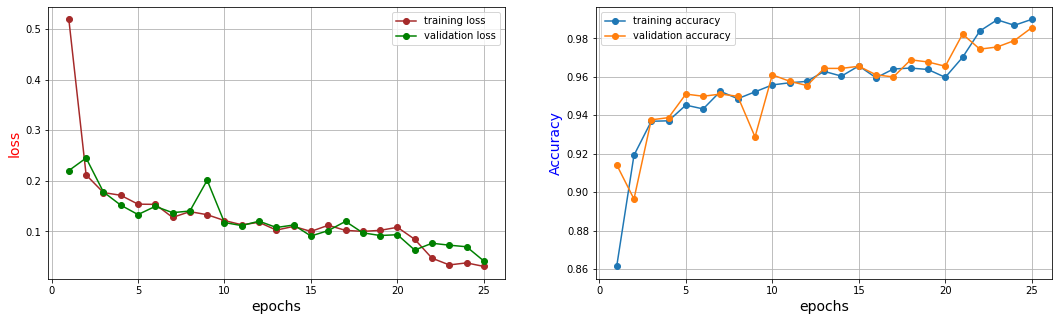

In [ ]:
# Plot training & validation loss/accuracy values
import matplotlib.pyplot as plt

fig,ax = plt.subplots(ncols=2, figsize=(18,5))

ax[0].plot(range(1,26),
           history.history['loss']+history2.history['loss'], 
           label='training loss',
           color="brown", 
           marker="o")
ax[0].plot(range(1,26),
           history.history['val_loss']+history2.history['val_loss'], 
           label='validation loss',
           color="green", 
           marker="o")

ax[0].set_xlabel("epochs", fontsize = 14)

ax[0].set_ylabel("loss",
              color="red",
              fontsize=14)
ax[0].legend(loc='best')
ax[0].grid(True)

# ax[1]=ax.twinx()
ax[1].plot(range(1,26),
           history.history['accuracy']+history2.history['accuracy'],
         label='training accuracy',
        #  color="blue",
         marker="o")
ax[1].plot(range(1,26),
           history.history['val_accuracy']+history2.history['val_accuracy'],
         label='validation accuracy',
        #  color="blue",
         marker="o")

ax[1].set_xlabel("epochs", fontsize = 14)

ax[1].set_ylabel("Accuracy",color="blue",fontsize=14)

ax[1].legend(loc='best')
ax[1].grid(True)

fig.show()

In [ ]:
best_model = tf.keras.models.load_model('/content/drive/MyDrive/Mask_models/vgg16')

In [ ]:
eval = best_model.evaluate(val_generator)

29/29 [==============================] - 10s 262ms/step - loss: 0.0458 - accuracy: 0.9866


In [ ]:
print('Evaluation Accuracy : {:.1f}%'.format(100*eval[1]),'\nEvaluation Loss : {:.6f}'.format(eval[0]))

Evaluation Accuracy : 98.7% 
Evaluation Loss : 0.045850


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_test = val_generator.classes
x_test = val_generator.filepaths
y_pred = []

def prepare(impath):
  img = cv2.imread(impath)
  img = cv2.resize(img,(128,128))
  return img.reshape(-1,128,128,3)

for i in x_test:
  img = prepare(i)
  pred = best_model.predict(img)
  # print(pred)
  y_pred.append(np.argmax(pred))

y_pr = np.array(y_pred)
# print classification report

In [ ]:
# 0 -> mask_weared_incorrect
# 1 -> with_mask
# 2 -> without_mask

print(classification_report(y_test, y_pr))
print('\nConfusion matrix: \n')
print(confusion_matrix(y_test, y_pr))

              precision    recall  f1-score   support

           0       1.00      0.01      0.03       299
           1       0.46      1.00      0.63       300
           2       1.00      0.81      0.89       299

    accuracy                           0.61       898
   macro avg       0.82      0.61      0.52       898
weighted avg       0.82      0.61      0.52       898


Confusion matrix: 

[[  4 295   0]
 [  0 300   0]
 [  0  58 241]]
